In [1]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

# custom classes and functions
import models
from models.blocks import ConvBlock, TransposeConvBlock, ResConvBlock, CategoricalStraightThrough
from models.mlp import MLP
from models.autoencoder import Autoencoder
from models.vae import VAE
from models.categorical_vae import CategoricalVAE
from preprocessing import grayscale_transform as transform

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Set Hyperparameters

In [46]:
batch_size = 8

A = 2 # number of action dimensions (3 for toy, 2 for real sim)
H = 512 # discrete h state 
Z = 32*32 # stochastic Zx1 state

## RSSM

In [47]:
class RSSM(nn.Module):
    def __init__(self):
        super(RSSM, self).__init__()
        
        # init the VAE
        self.vae = CategoricalVAE(greyscale=True, vae_ent_coeff=1e-8)
        
        # init the RNN
        self.num_rnn_layers = 1
        self.rnn = nn.GRU(input_size=A+H+Z, hidden_size=H, num_layers=self.num_rnn_layers)
        
        # init MLPs
        self.dynamics_mlp = MLP(input_dims=H, output_dims=Z) # H -> Z
        self.reward_mlp = MLP(input_dims=H+Z+A, output_dims=1) # state (H+Z) -> 1
        self.continue_mlp = MLP(input_dims=H+Z+A, output_dims=1) # state (H+Z)->1 # add sigmoid and BinaryCE
    
    
    def forward(self, x, h):
        # predict z and generate the true stochastic latent variable z with the encoder
        z_pred = rssm.dynamics_mlp(h).view(-1, Z) # B,1024 (flattened)
        z = self.vae.encode(x).view(-1, Z)
        
        # concatenate z with current hidden state h (+flatten) to form current state
        state = torch.cat((h.view(-1, H), z), 1)
        
        # apply external actor and critic nets on state
        action = policy_net(state) # a is a 2x1 vector
        v = value_net(state)
        
        state_with_action = torch.cat((state, action), 1)
        
        # predict the reward and continue flag
        reward = rssm.reward_mlp(state_with_action)
        continue_flag = rssm.continue_mlp(state_with_action) # binary classification
        
        # apply RNN to obtain the next hidden state
        _, h = self.rnn(state_with_action, h.view(-1, H))
        
        return h, action, v, reward, continue_flag
    
    # def info(self):
    # - look at VAE.info() 
    
    # def print_num_params(self):
    #     print(f"RSSM ==> number of parameters: {sum(p.numel() for p in rssm.parameters() if p.requires_grad):_}")

In [48]:
rssm = RSSM().to(device)

rssm_optim = optim.Adam(
    rssm.parameters(), 
    lr=1e-3,
    weight_decay=1e-5 # l2 regularization
)

In [49]:
value_net = MLP(input_dims=H+Z, output_dims=1).to(device) # state (H+Z) -> 1
policy_net = MLP(input_dims=H+Z, output_dims=A).to(device) # state (H+Z) -> A

## Training loop

In [50]:
""" vae training loop """

# create the environment
toy_env = False

if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=40, render_mode="rgb_array")
else:
    assert A==2
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

verbose = True
n_episodes = 100
vae_losses, reconstruction_losses, entropy_losses = [], [], []
rssm.train()

for episode in range(n_episodes): # tqdm
    
    # get the initial state
    obs, info = env.reset()
    
    # reset the rnn's hidden state
    h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H
    
    # setup a minibatch of x's for training the autoencoder
    batch_counter = 0
    batch_tensor = torch.empty((batch_size,) + transform(obs).shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        x = transform(obs).view(-1, 1, 128, 128)
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        """ train networks on accumulated batch """
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat = rssm.vae(batch_tensor)

            # get a loss and update the autoencoder
            vae_loss, reconstruction_loss, weighted_entropy_loss = rssm.vae.get_loss(batch_tensor, xhat)
            rssm_optim.zero_grad()
            vae_loss.backward()
            rssm_optim.step()
            
            vae_losses.append(vae_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            entropy_losses.append(weighted_entropy_loss.item())
        
        # predict one step using the RSSM and apply the actor-critic
        h, action, v, reward, continue_flag = rssm(x, h)
        
        # choose and execute an action
        next_obs, reward, terminated, truncated, info = env.step(action.squeeze().detach().cpu().numpy())        
               
        done = terminated or truncated
        obs = next_obs
    
    if verbose: 
        print(f"train episode [{episode}/{n_episodes}] ===> Loss: {vae_loss.item():.3f}, ReconstructionLoss: {reconstruction_loss.item():.3f}, weighted_entropy_loss: {weighted_entropy_loss.item():.3f}")
        
env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


train episode [0/100] ===> Loss: 1.231, ReconstructionLoss: 1.231, weighted_entropy_loss: -0.000
train episode [1/100] ===> Loss: 1.103, ReconstructionLoss: 1.103, weighted_entropy_loss: -0.000
train episode [2/100] ===> Loss: 1.307, ReconstructionLoss: 1.307, weighted_entropy_loss: -0.000
train episode [3/100] ===> Loss: 1.141, ReconstructionLoss: 1.141, weighted_entropy_loss: -0.000
train episode [4/100] ===> Loss: 1.115, ReconstructionLoss: 1.115, weighted_entropy_loss: -0.000
train episode [5/100] ===> Loss: 1.051, ReconstructionLoss: 1.051, weighted_entropy_loss: -0.000
train episode [6/100] ===> Loss: 1.117, ReconstructionLoss: 1.117, weighted_entropy_loss: -0.000
train episode [7/100] ===> Loss: 1.067, ReconstructionLoss: 1.067, weighted_entropy_loss: -0.000
train episode [8/100] ===> Loss: 0.922, ReconstructionLoss: 0.922, weighted_entropy_loss: -0.000
train episode [9/100] ===> Loss: 0.940, ReconstructionLoss: 0.940, weighted_entropy_loss: -0.000
train episode [10/100] ===> Lo

KeyboardInterrupt: 

## Plot results

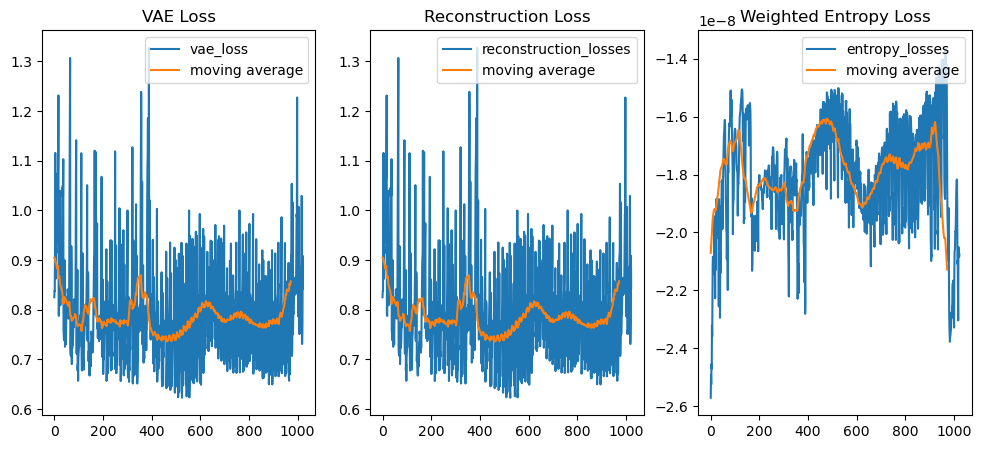

In [64]:
rolling_length = max(1, int(len(vae_losses)/20))

fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("VAE Loss")
vae_losses_moving_average = (
    np.convolve(
        np.array(vae_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(vae_losses)), vae_losses, label="vae_loss")
axs[0].plot(range(len(vae_losses_moving_average)), vae_losses_moving_average, label="moving average")
axs[0].legend(loc="upper right")


axs[1].set_title("Reconstruction Loss")
reconstruction_losses_moving_average = (
    np.convolve(
        np.array(reconstruction_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(reconstruction_losses)), reconstruction_losses, label="reconstruction_losses")
axs[1].plot(range(len(reconstruction_losses_moving_average)), reconstruction_losses_moving_average, label="moving average")
axs[1].legend(loc="upper right")

axs[2].set_title("Weighted Entropy Loss")
entropy_losses_moving_average = (
    np.convolve(
        np.array(entropy_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(entropy_losses)), entropy_losses, label="entropy_losses")
axs[2].plot(range(len(entropy_losses_moving_average)), entropy_losses_moving_average, label="moving average")
axs[2].legend(loc="upper right");

# Overfitting and visualization playground

In [67]:
""" overfit to one sample """
overfit = False

if overfit:
    batch_tensor = torch.load("batch_tensor.pt").to(device)
    vae_losses, reconstruction_losses, entropy_losses = [], [], []
    
    for i in range(200):
        
        xhat = vae(batch_tensor)
    
        # get a loss and update the autoencoder
        vae_loss, reconstruction_loss, entropy_loss = vae.get_loss(batch_tensor, xhat)
        vae_optim.zero_grad()
        vae_loss.backward()
        vae_optim.step()
    
        vae_losses.append(vae_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        entropy_losses.append(entropy_loss.item())
    
        if i % 20 == 0:
            print(f"[{i+1}/{200}] loss: {vae_loss.item()}, entropy loss: {entropy_loss}, lr: {get_lr(vae_optim)}")

In [71]:
visualize = False

if visualize:
    batch_tensor = torch.load("batch_tensor.pt").to(device)
    
    """ show the observation """
    plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
    
    """ show the reconstruction """
    rssm.vae.eval()
    with torch.no_grad():
        xhat = rssm.vae(batch_tensor)
        plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")
        plt.show()
    rssm.vae.train();